In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import time

np.random.seed(42)

eps = 1e-3


# 1. GD cho hàm 1 biến
* $f(x) = \frac{1}{2} (x - 1)^{2} - 2$
* $f'(x) = x - 1$

In [2]:
def grad1(x):
    return x - 1

def cost1(x):
    return 0.5*(x - 1)**2 - 2

def my_gd1(eta, x0, max_iter = 100):
    x = [x0]
    for it in range(max_iter):
        x_old = x[-1]
        x_new = x_old - eta * grad1(x_old)
        x.append(x_new)

        if abs(x_new - x_old) < eps:
            return x, it + 1
    return x, max_iter

(x1, it1) = my_gd1(0.1, 0)
print(f"x* = {x1[-1]:.6f}, f(x*) = {cost1(x1[-1]):.6f}, obtained after {it1} iterations")

x* = 0.991272, f(x*) = -1.999962, obtained after 45 iterations


# 2. GD cho hàm nhiều biến:
* $\mathcal{L}(\mathbf{w}) = \frac{1}{2N}||\mathbf{y} - \bar{\mathbf{X}}\mathbf{w}||_2^2$
* $\nabla_{\mathbf{w}}\mathcal{L}(\mathbf{w}) = \frac{1}{N}\bar{\mathbf{X}}^T(\bar{\mathbf{X}}\mathbf{w} - \mathbf{y})$

### Tìm nghiệm tối ưu sử dụng GD


In [3]:
X = np.random.rand(1000, 1)
y = 4 + 3 * X + .2*np.random.randn(1000, 1) # noise added

one = np.ones((X.shape[0],1))
Xbar = np.concatenate((one, X), axis = 1)

def grad2(w):
    N = Xbar.shape[0]
    return 1/N * Xbar.T.dot(Xbar.dot(w) - y)

def cost2(w):
    N = Xbar.shape[0]
    return .5/N*np.linalg.norm(y - Xbar.dot(w), 2)**2

def my_gd2(w_init, eta, max_iter = 1000):
    w = [w_init]
    costs = [cost2(w_init)]
    for it in range(max_iter):
        w_new = w[-1] - eta*grad2(w[-1])
        w.append(w_new)
        costs.append(cost2(w_new))

        if np.linalg.norm(grad2(w_new))/len(w_new) < eps:
            return w, it + 1, costs

    return w, max_iter, costs

(w2, it2, costs_batch) = my_gd2(np.array([[2], [1]]), 0.1)
print(f"w* = {w2[-1].T}, obtained after {it2} iterations")

w* = [[4.04863216 2.94303801]], obtained after 485 iterations


### Đối chiếu với nghiệm tối ưu sử dụng công thức
* $\mathbf{w} = \mathbf{A}^{-1}\mathbf{b} = (\bar{\mathbf{X}}^T\bar{\mathbf{X}})^{-1}\bar{\mathbf{X}}^T\mathbf{y}$

In [4]:
A = np.dot(Xbar.T, Xbar)
b = np.dot(Xbar.T, y)
w_lr = np.dot(np.linalg.pinv(A), b)
print(f"w* = {w_lr.T}")

w* = [[4.03495605 2.96904297]]


# 3. GD + momentum, so sánh khi có / không momentum
* $f(x) = x^2 + 10sin(x)$
* $f'(x) = 2x + 10cos(x)$

In [5]:
def grad3(x):
    return 2*x + 10*np.cos(x)

def cost3(x):
    return x**2 + 10*np.sin(x)

def gd_momentum(x_init, eta, gamma, max_iter=1000):
    x = [float(x_init)]
    v_old = 0.0
    for it in range(max_iter):
        v_new = gamma * v_old + eta * grad3(x[-1])
        x_new = x[-1] - v_new
        x.append(x_new)
        v_old = v_new

        if abs(grad3(x_new)) < eps:
            return x, it + 1

    return x, max_iter

x3, it3 = gd_momentum(5, 0.1, 0)
print(f"GD without momentum: x = {x3[-1]:.6f}, obtained after {it3} iterations")

x3_, it3_ = gd_momentum(5, 0.1, 0.9)
print(f"GD  with   momentum: x = {x3_[-1]:.6f}, obtained after {it3_} iterations")

GD without momentum: x = 3.837359, obtained after 5 iterations
GD  with   momentum: x = -1.306463, obtained after 148 iterations


* Visualization

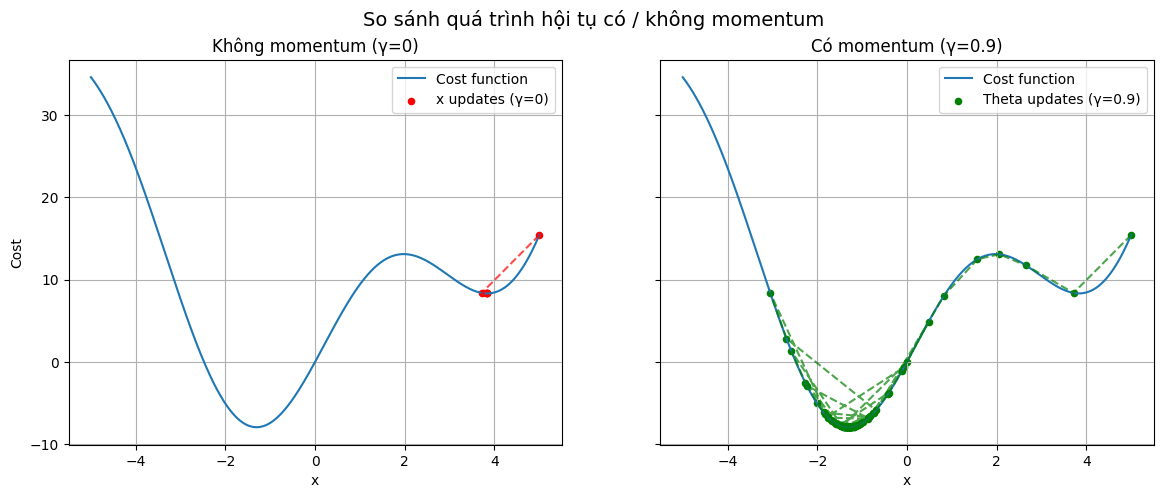

In [6]:
x_hist, it_hist = gd_momentum(5, 0.1, 0) # Không momentum
x1_hist, it1_hist = gd_momentum(5, 0.1, 0.9) # Có momentum

fig, axes = plt.subplots(1, 2, figsize=(14,5), sharey=True)

x_vals = np.linspace(-5, 5, 400)
cost_vals = cost3(x_vals)

# Trường hợp không momentum
axes[0].plot(x_vals, cost_vals, label='Cost function')
axes[0].scatter(x_hist, [cost3(t) for t in x_hist], color='red', s=20, label='x updates (γ=0)')
axes[0].plot(x_hist, [cost3(t) for t in x_hist], 'r--', alpha=0.7)
axes[0].set_title('Không momentum (γ=0)')
axes[0].set_xlabel('x')
axes[0].set_ylabel('Cost')
axes[0].grid(True)
axes[0].legend()

# Trường hợp có momentum
axes[1].plot(x_vals, cost_vals, label='Cost function')
axes[1].scatter(x1_hist, [cost3(t) for t in x1_hist], color='green', s=20, label='Theta updates (γ=0.9)')
axes[1].plot(x1_hist, [cost3(t) for t in x1_hist], 'g--', alpha=0.7)
axes[1].set_title('Có momentum (γ=0.9)')
axes[1].set_xlabel('x')
axes[1].grid(True)
axes[1].legend()

plt.suptitle('So sánh quá trình hội tụ có / không momentum', fontsize=14)
plt.show()

# 4. GD + Nesterov accelerated gradient (NAG), so sánh momentum vs NAG
* $f(x) = x^2 + 10sin(x)$
* $f'(x) = 2x + 10cos(x)$

In [7]:
def grad4(x):
    return 2*x + 10*np.cos(x)

def cost4(x):
    return x**2 + 10*np.sin(x)

def gd_nag(x_init, eta, gamma, max_iter=1000):
    x = [float(x_init)]
    v_old = 0.0
    for it in range(max_iter):
        # Lookahead position
        lookahead_x = x[-1] - gamma * v_old
        # Compute gradient at lookahead position
        gradient = grad4(lookahead_x)
        # Update velocity
        v_new = gamma * v_old + eta * gradient
        # Update parameters
        x_new = x[-1] - v_new
        x.append(x_new)
        v_old = v_new

        if abs(grad4(x_new)) < eps:
            return x, it + 1

    return x, max_iter
x4, it4 = gd_nag(5, 0.1, 0.9)
print(f"GD with      NAG: x = {x4[-1]:.6f}, obtained after {it4} iterations")

x4_, it4_ = gd_momentum(5, 0.1, 0.9)
print(f"GD with momentum: x = {x4_[-1]:.6f}, obtained after {it4_} iterations")

GD with      NAG: x = -1.306496, obtained after 20 iterations
GD with momentum: x = -1.306463, obtained after 148 iterations


# 5. Stochastc Gradient Descent (SGD):
* $\mathcal{L}(\mathbf{w}) = \frac{1}{2N}||\mathbf{y} - \bar{\mathbf{X}}\mathbf{w}||_2^2 = \frac{1}{2N} \sum_{i=1}^{N} (y_i - \mathbf{x}_i \mathbf{w})^2$
* $\nabla_{\mathbf{w}}\mathcal{L}(\mathbf{w}) = \frac{1}{N}\bar{\mathbf{X}}^T(\bar{\mathbf{X}}\mathbf{w} - \mathbf{y}) = \frac { 1 } { N } \sum _ { i = 1 } ^ { N } { \bf x } _ { i } ^ { T } ( { \bf x } _ { i } { \bf w } - y _ { i } )$


In [8]:
def sgrad(w, i, rd_id):
    true_i = rd_id[i]
    xi = Xbar[true_i, :] # shape (2,)
    yi = y[true_i]
    a = np.dot(xi, w) - yi # scalar
    return (xi*a).reshape(2, 1)

def sgd(w_init, eta, max_iter=10):
    w = [w_init]
    costs = [cost2(w_init)]
    w_last_check = w_init
    iter_check_w = 10
    N = X.shape[0]
    count = 0
    for it in range(max_iter):
        # shuffle data
        rd_id = np.random.permutation(N)
        for i in range(N):
            count += 1
            gradient = sgrad(w[-1], i, rd_id)
            w_new = w[-1] - eta * gradient
            w.append(w_new)
            costs.append(cost2(w_new))
            if count % iter_check_w == 0:
                w_this_check = w_new
                if np.linalg.norm(w_this_check - w_last_check)/len(w_init) < eps:
                    return w, count, costs
                w_last_check = w_this_check
    return w, max_iter * N, costs

(w5, it5, costs_sgd) = sgd(np.array([[2], [1]]), 0.1)
print(f"w* = {w5[-1].T}, weight updates: {it5}")

w* = [[3.95890072 2.93459069]], weight updates: 7480


# 6. Mini-batch Gradient Descent

In [9]:
def mbgrad(w, batch_indices):
    batch_size = len(batch_indices)
    X_batch = Xbar[batch_indices]  # shape: (batch_size, 2)
    y_batch = y[batch_indices]     # shape: (batch_size, 1)

    a = X_batch.dot(w) - y_batch  # shape: (batch_size, 1)
    return (1/batch_size) * X_batch.T.dot(a)  # shape: (2, 1)

def mbgd(w_init, eta, batch_size=32, max_epochs=10):
    w = [w_init]
    costs = [cost2(w_init)]
    w_last_check = w_init
    check_interval = 10
    N = X.shape[0]
    count = 0

    for epoch in range(max_epochs):
        # Shuffle data
        rd_id = np.random.permutation(N)

        # Chia thành các mini-batches
        for i in range(0, N, batch_size):
            if i + batch_size > N:
                continue  # Bỏ qua batch cuối nếu không đủ size

            batch_indices = rd_id[i:i+batch_size]
            count += 1

            g = mbgrad(w[-1], batch_indices)
            w_new = w[-1] - eta * g
            w.append(w_new)
            costs.append(cost2(w_new))

            if count % check_interval == 0:
                if np.linalg.norm(w_new - w_last_check)/len(w_init) < eps:
                    return w, count * batch_size, costs
                w_last_check = w_new
    return w, count * batch_size, costs

(w6, it6, costs_mb) = mbgd(np.array([[2], [1]]), 0.1)
print(f"w* = {w6[-1].T}, weight updates: {it6}")

w* = [[4.08119391 2.88132108]], weight updates: 9920
